In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from copy import deepcopy as dc

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
df=pd.read_csv("archive\TSLA.csv")

In [3]:
#To know about the different datatypes and the general look of the data.
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3000 non-null   object 
 1   Open       3000 non-null   float64
 2   High       3000 non-null   float64
 3   Low        3000 non-null   float64
 4   Close      3000 non-null   float64
 5   Adj Close  3000 non-null   float64
 6   Volume     3000 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 164.2+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
1,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500
3,2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500
4,2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000


<Axes: title={'center': 'Correlation Heatmap of Stock Data'}>

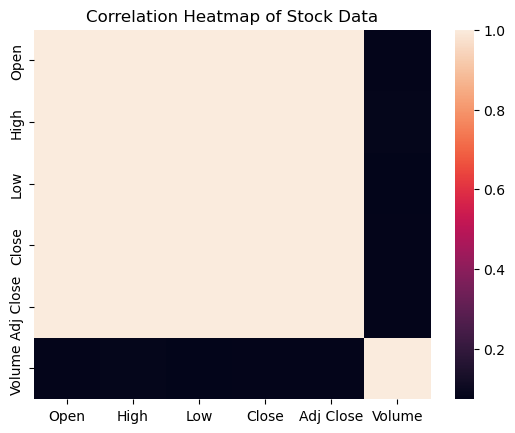

In [4]:
#To see the correlation between the different variables we have been given we use a heatmap. 
#It appears that apart from the volume all other variables are highly correlated. 
plt.title("Correlation Heatmap of Stock Data")
corr = df.select_dtypes("number").corr()
sns.heatmap(corr)

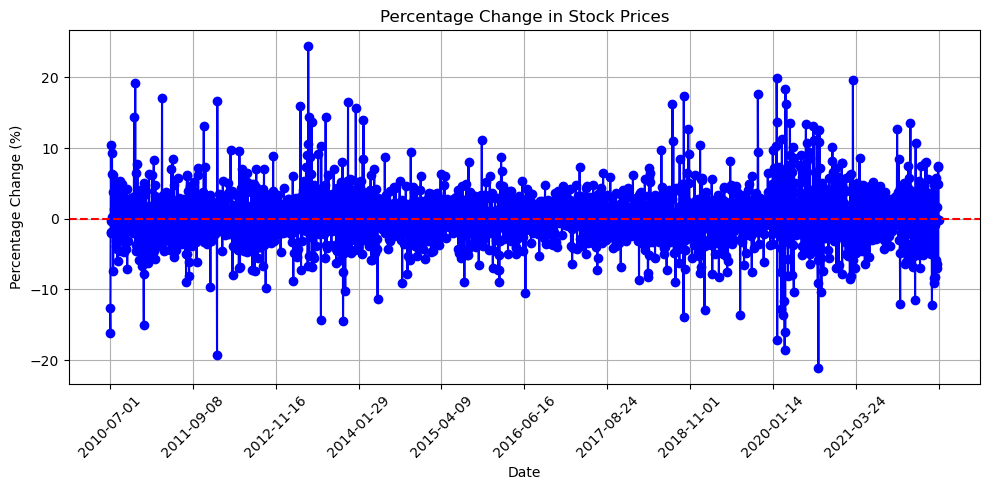

In [5]:
#Now let's make a graph to know about the volatility of the stock prices.
df["Pct_Change"] = df["Adj Close"].pct_change(periods=1) * 100.0

# Plotting the percentage change
plt.figure(figsize=(10, 5))
plt.plot(df["Date"], df["Pct_Change"], marker='o', color='b')
plt.title("Percentage Change in Stock Prices")
plt.xlabel("Date")
plt.ylabel("Percentage Change (%)")
plt.axhline(0, color="red", linestyle="--")  # Horizontal line at 0 for reference
plt.grid()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Show at most 12 ticks
plt.tight_layout()
plt.show()

#We can see that there is a maximum change of 20% in a stock's value for 2 consecutive days.

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
    a=a[1:]
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

print("The mean confidence interval is: ",mean_confidence_interval(df["Pct_Change"]))
print("This means that 95% of the time the average change in stock price lies between 0.1% and 3.6% of increase.")

The confidence interval is:  (0.10739342827461651, 0.3636954372972975)
This means that 95% of the time the average change in stock price lies between 0.1% and 3.6% of increase.


In [7]:
df.drop(columns=["Pct_Change"], inplace=True)#Dropping the column because we don't need it anymore.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3000 non-null   object 
 1   Open       3000 non-null   float64
 2   High       3000 non-null   float64
 3   Low        3000 non-null   float64
 4   Close      3000 non-null   float64
 5   Adj Close  3000 non-null   float64
 6   Volume     3000 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 164.2+ KB


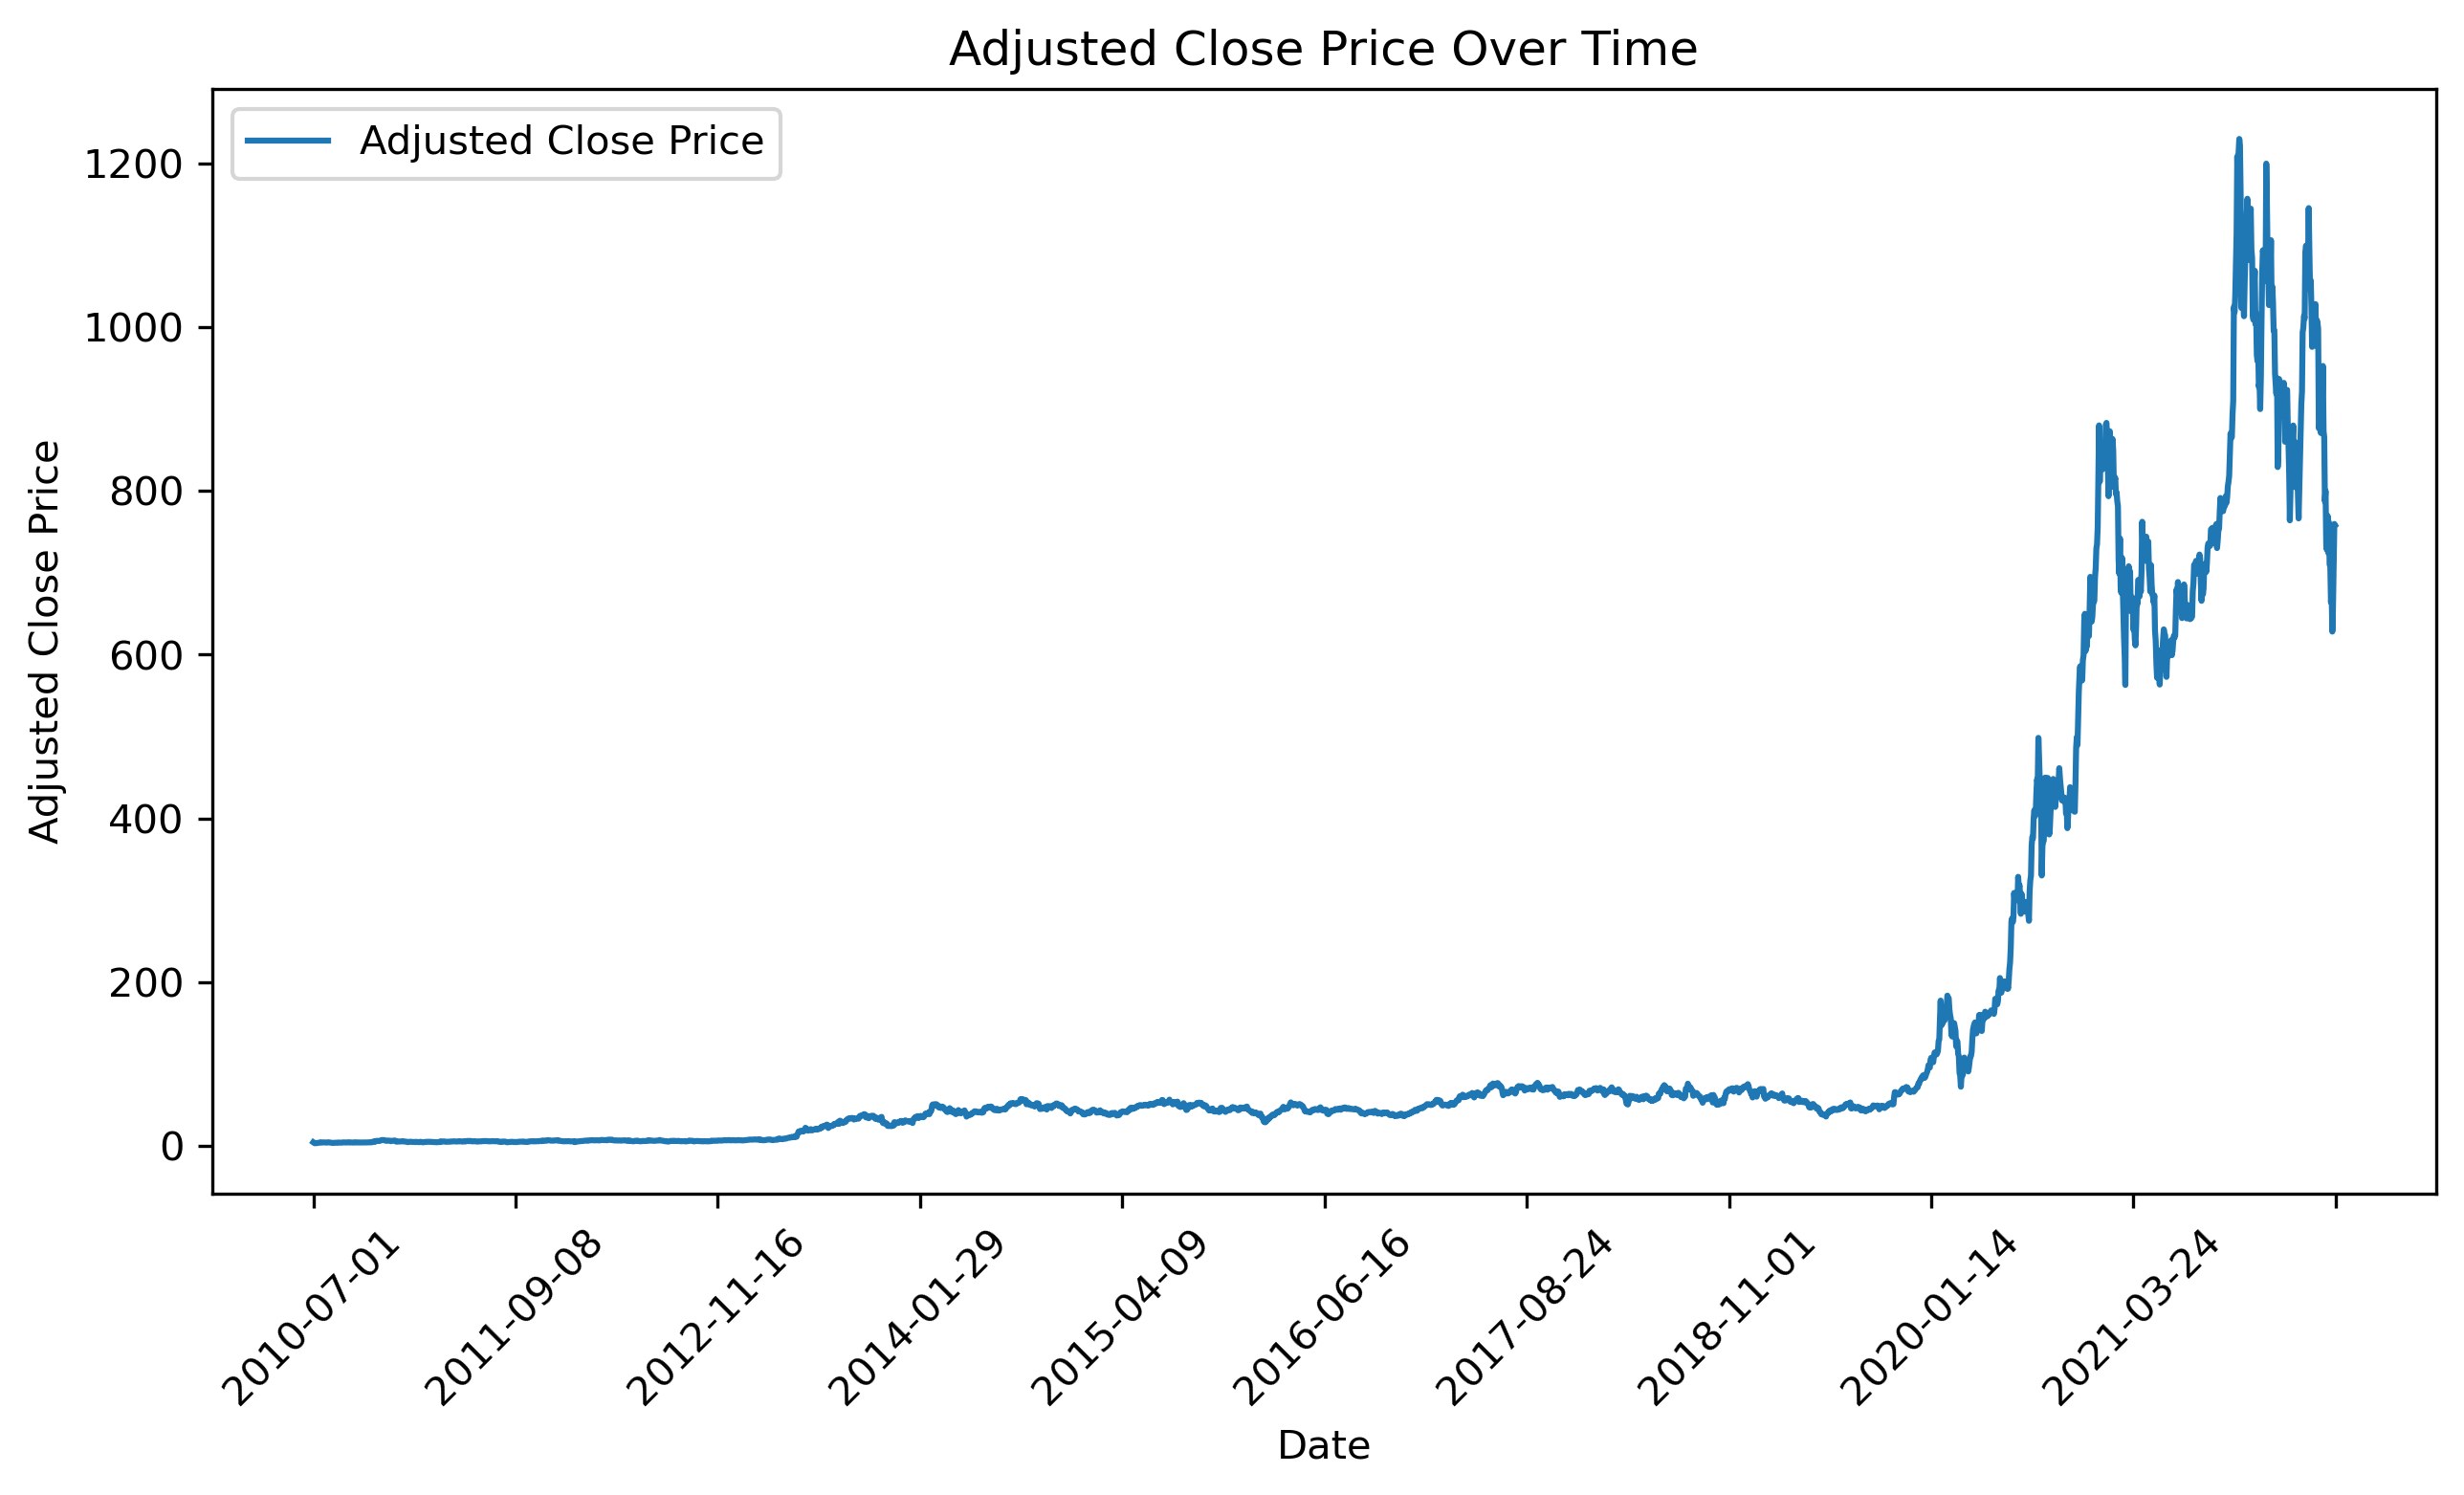

In [8]:
#Let's create a plot to see the past performance of the stock.
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(df["Date"], df["Adj Close"], label="Adjusted Close Price")
plt.xlabel("Date") 
plt.ylabel("Adjusted Close Price")
plt.title("Adjusted Close Price Over Time")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set x-axis tick frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Show at most 12 ticks

plt.legend()
plt.show()

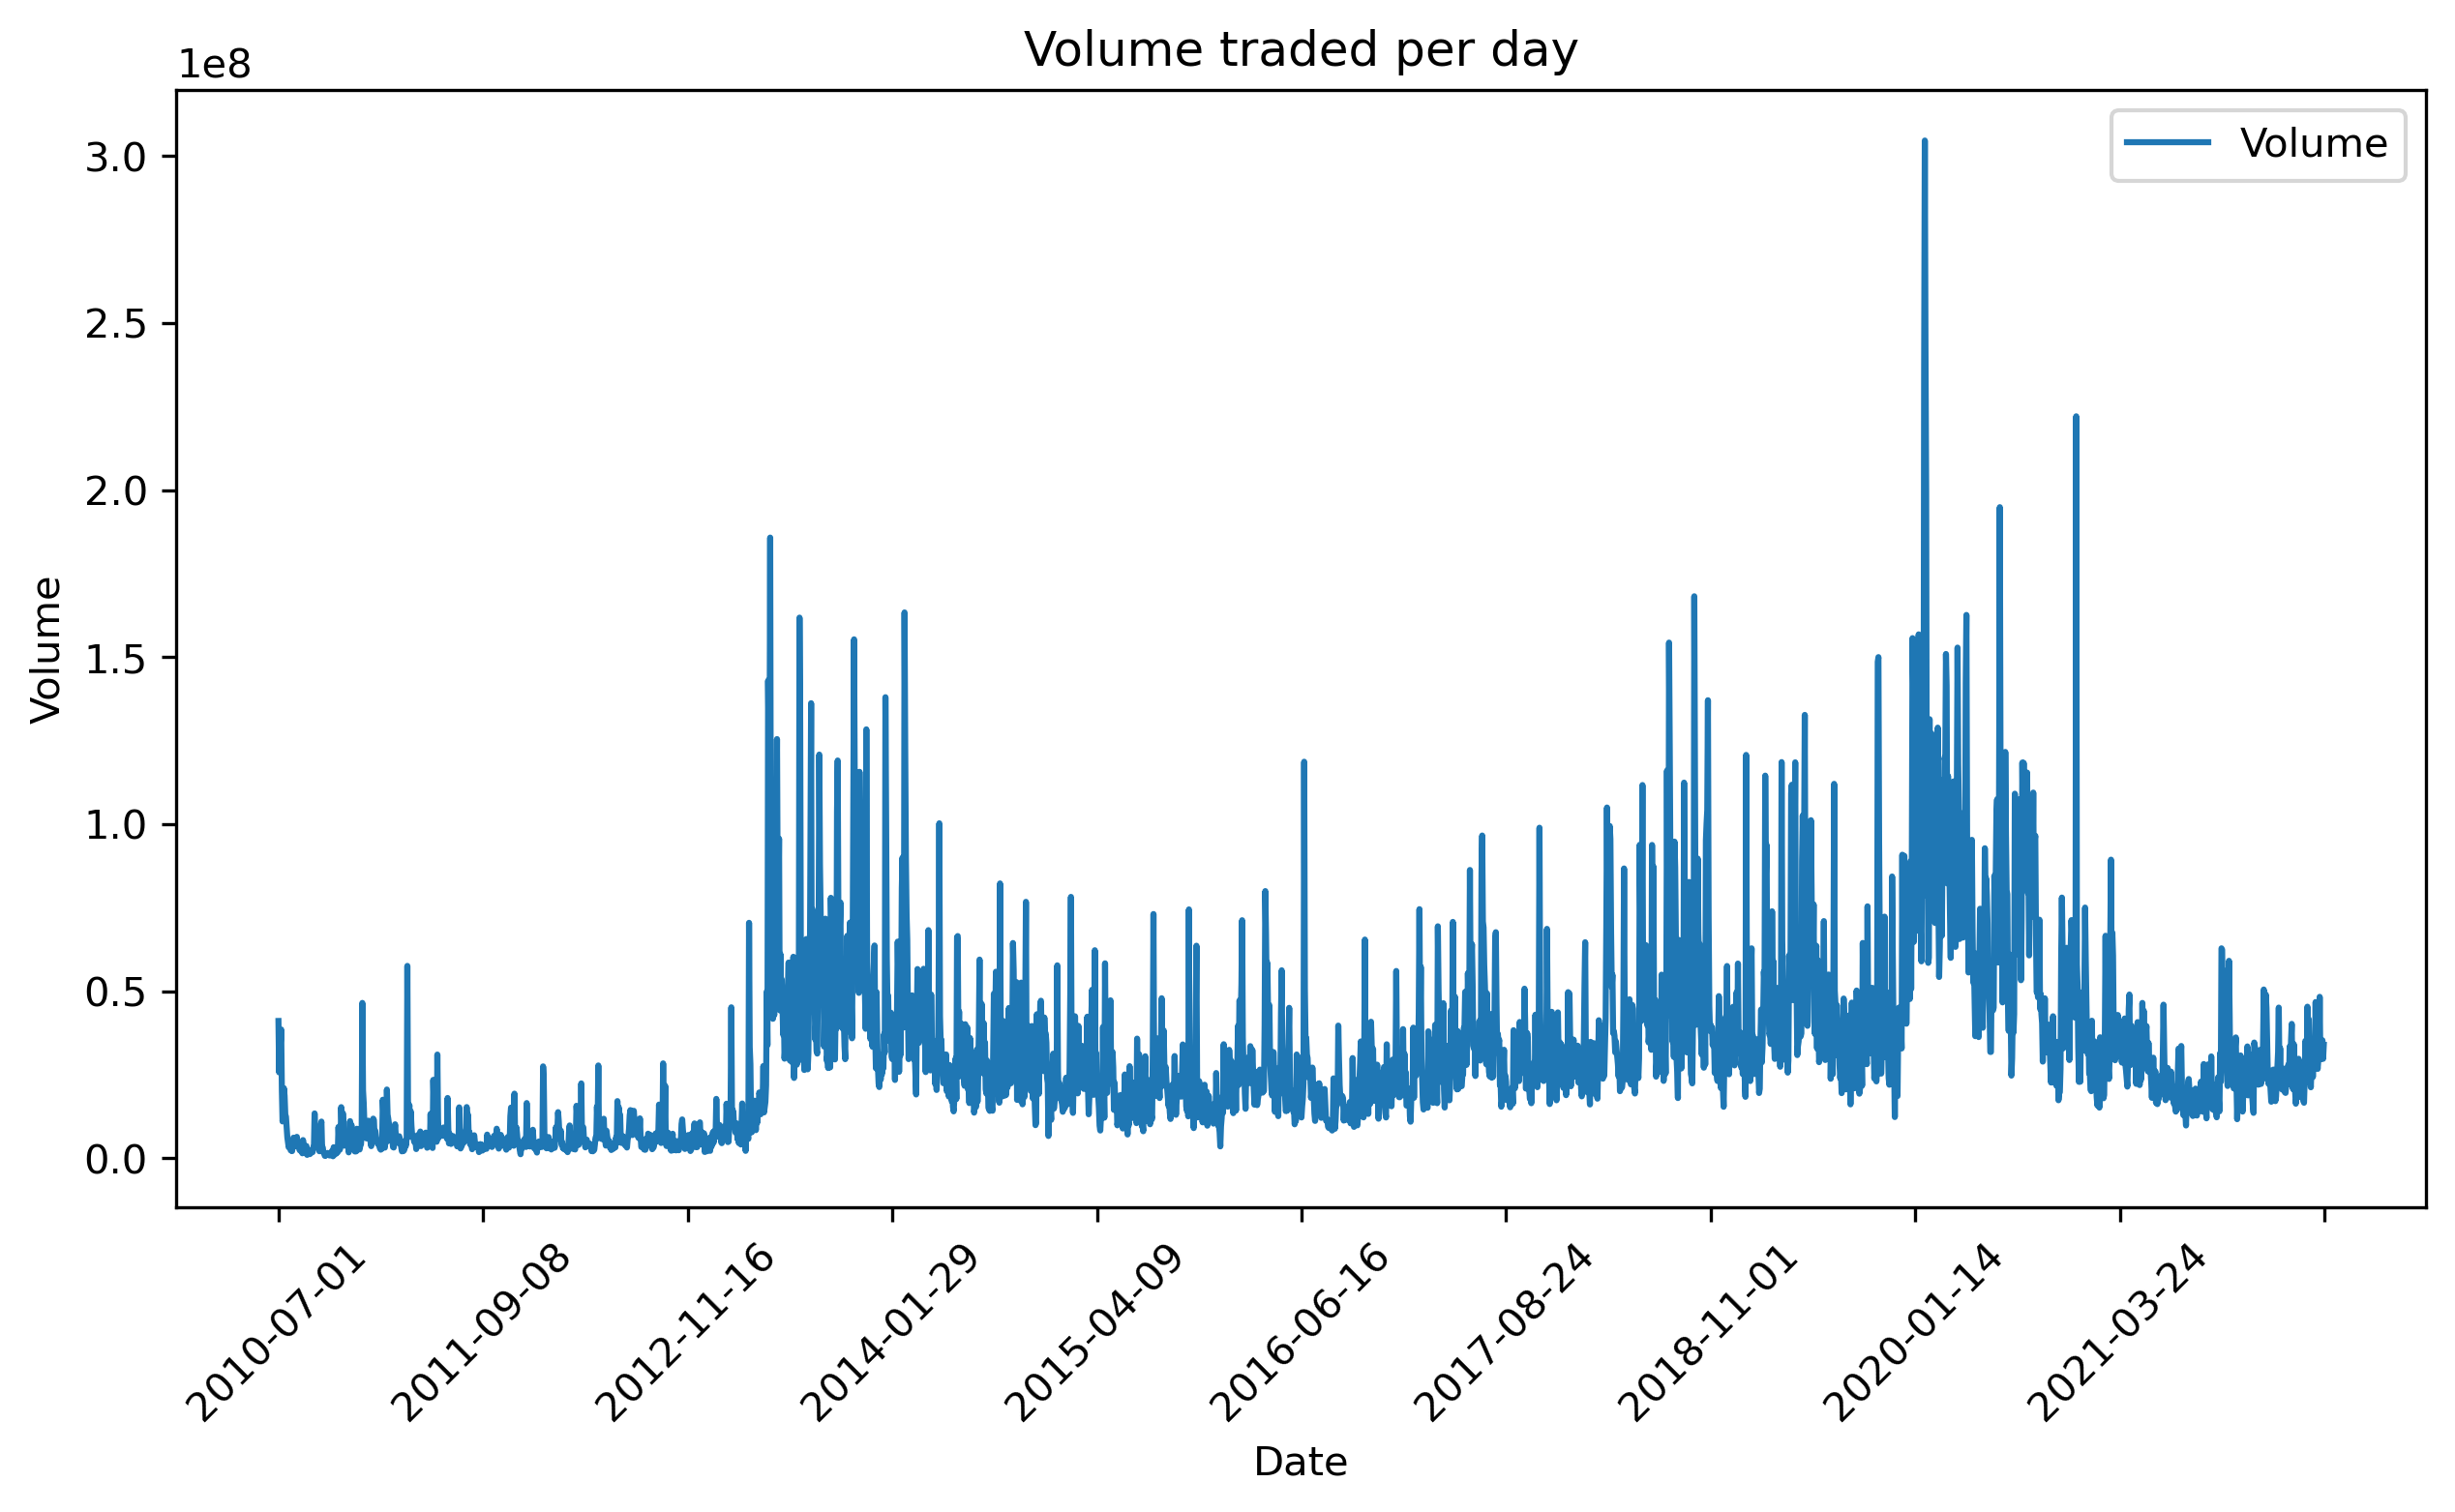

In [9]:
#Let's also analyse the volume of stock being traded every day.
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(df["Date"], df["Volume"], label="Volume")
plt.xlabel("Date") 
plt.ylabel("Volume")
plt.title("Volume traded per day")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set x-axis tick frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Show at most 12 ticks

plt.legend()
plt.show()

In [10]:
#Let's convert the type of date from object to datetime.
df["Date"]=pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

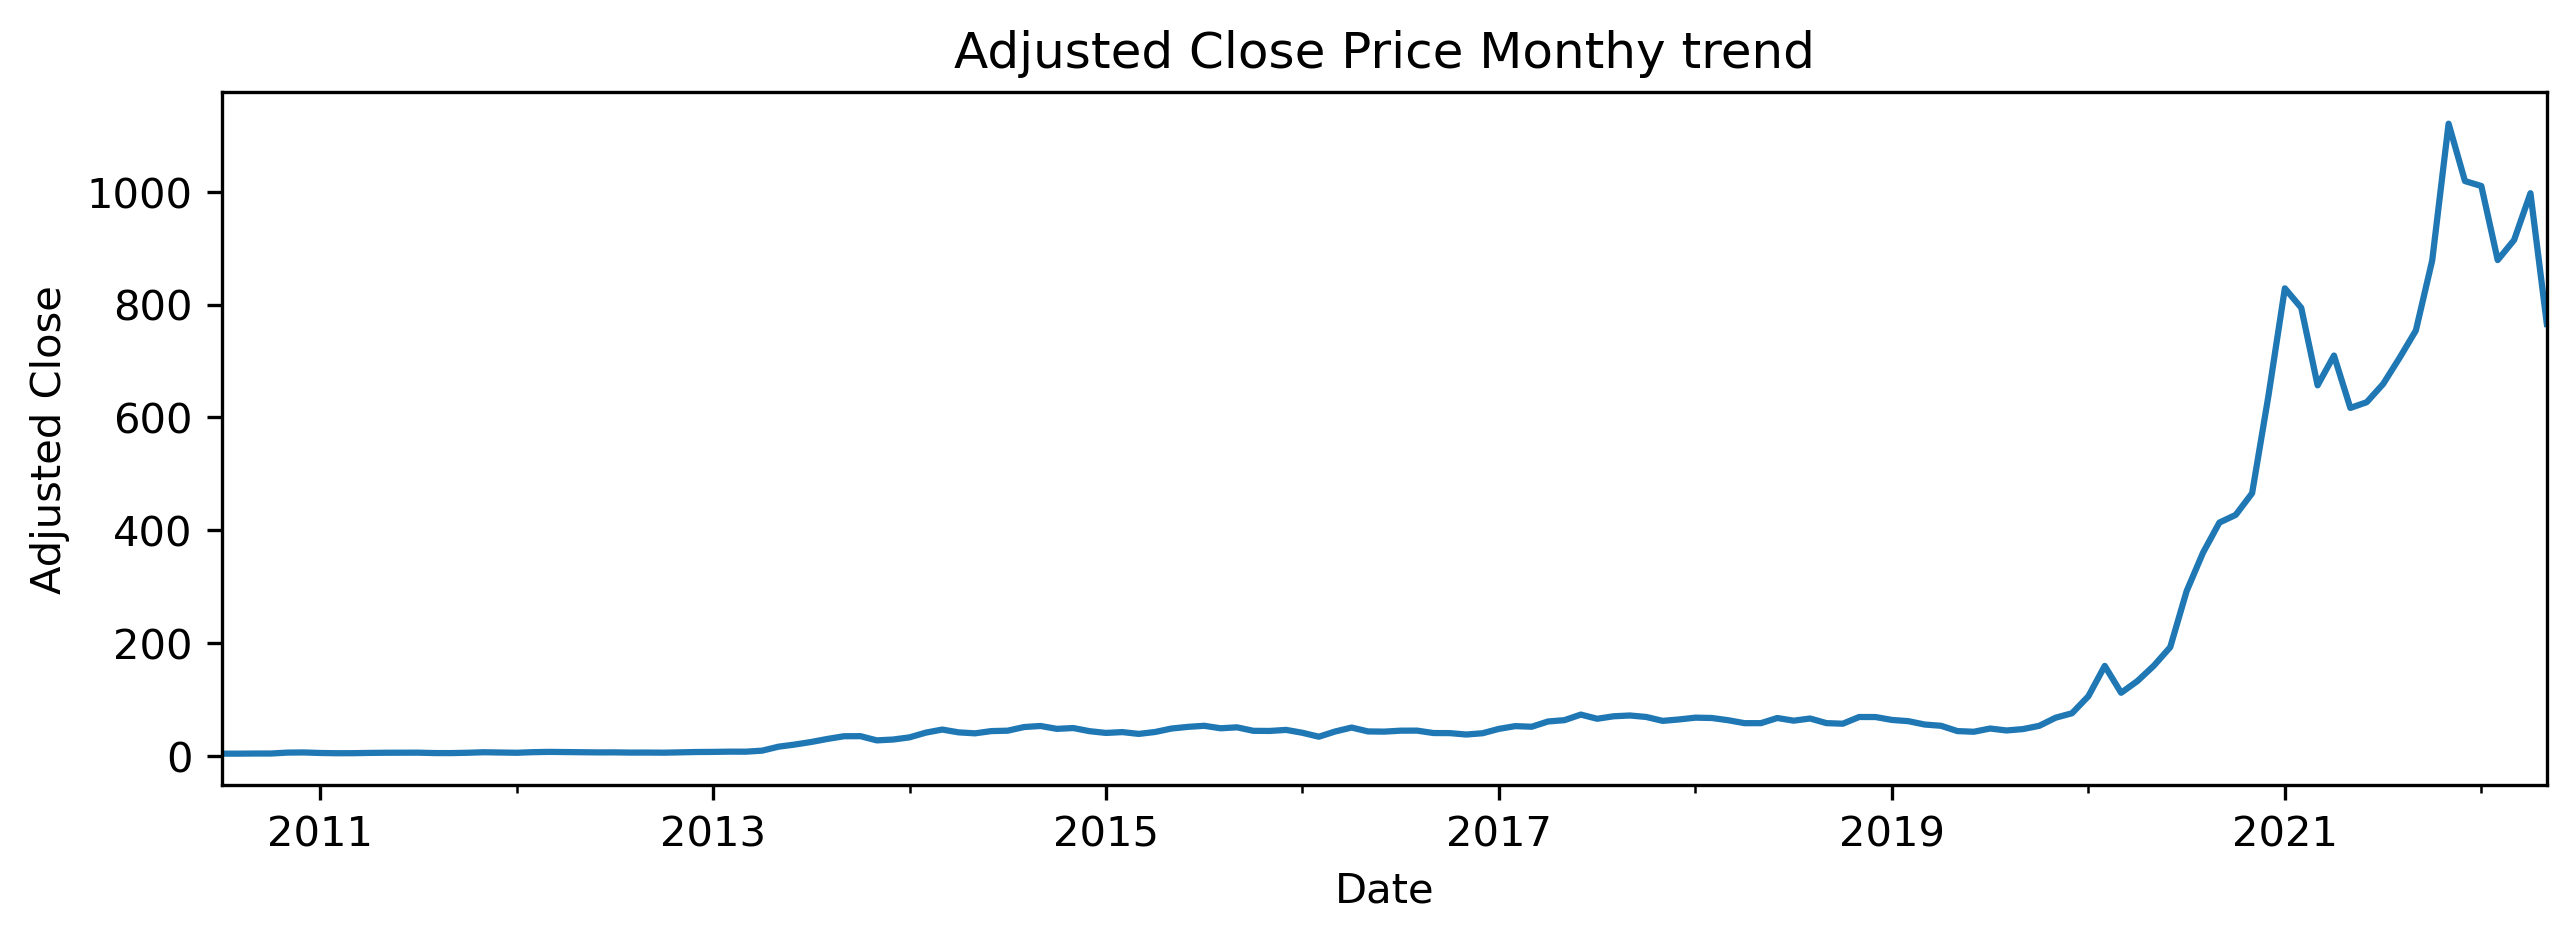

In [11]:
#Now let's view the monthly trend of the stock prics.
plt.figure(figsize=(10, 3), dpi=300)
df["Adj Close"].resample('M').mean().plot()
plt.xlabel("Date") 
plt.ylabel("Adjusted Close")
plt.title("Adjusted Close Price Monthy trend")
plt.show()

Text(0.5, 1.0, 'Adjusted Close Price Yearly trend')

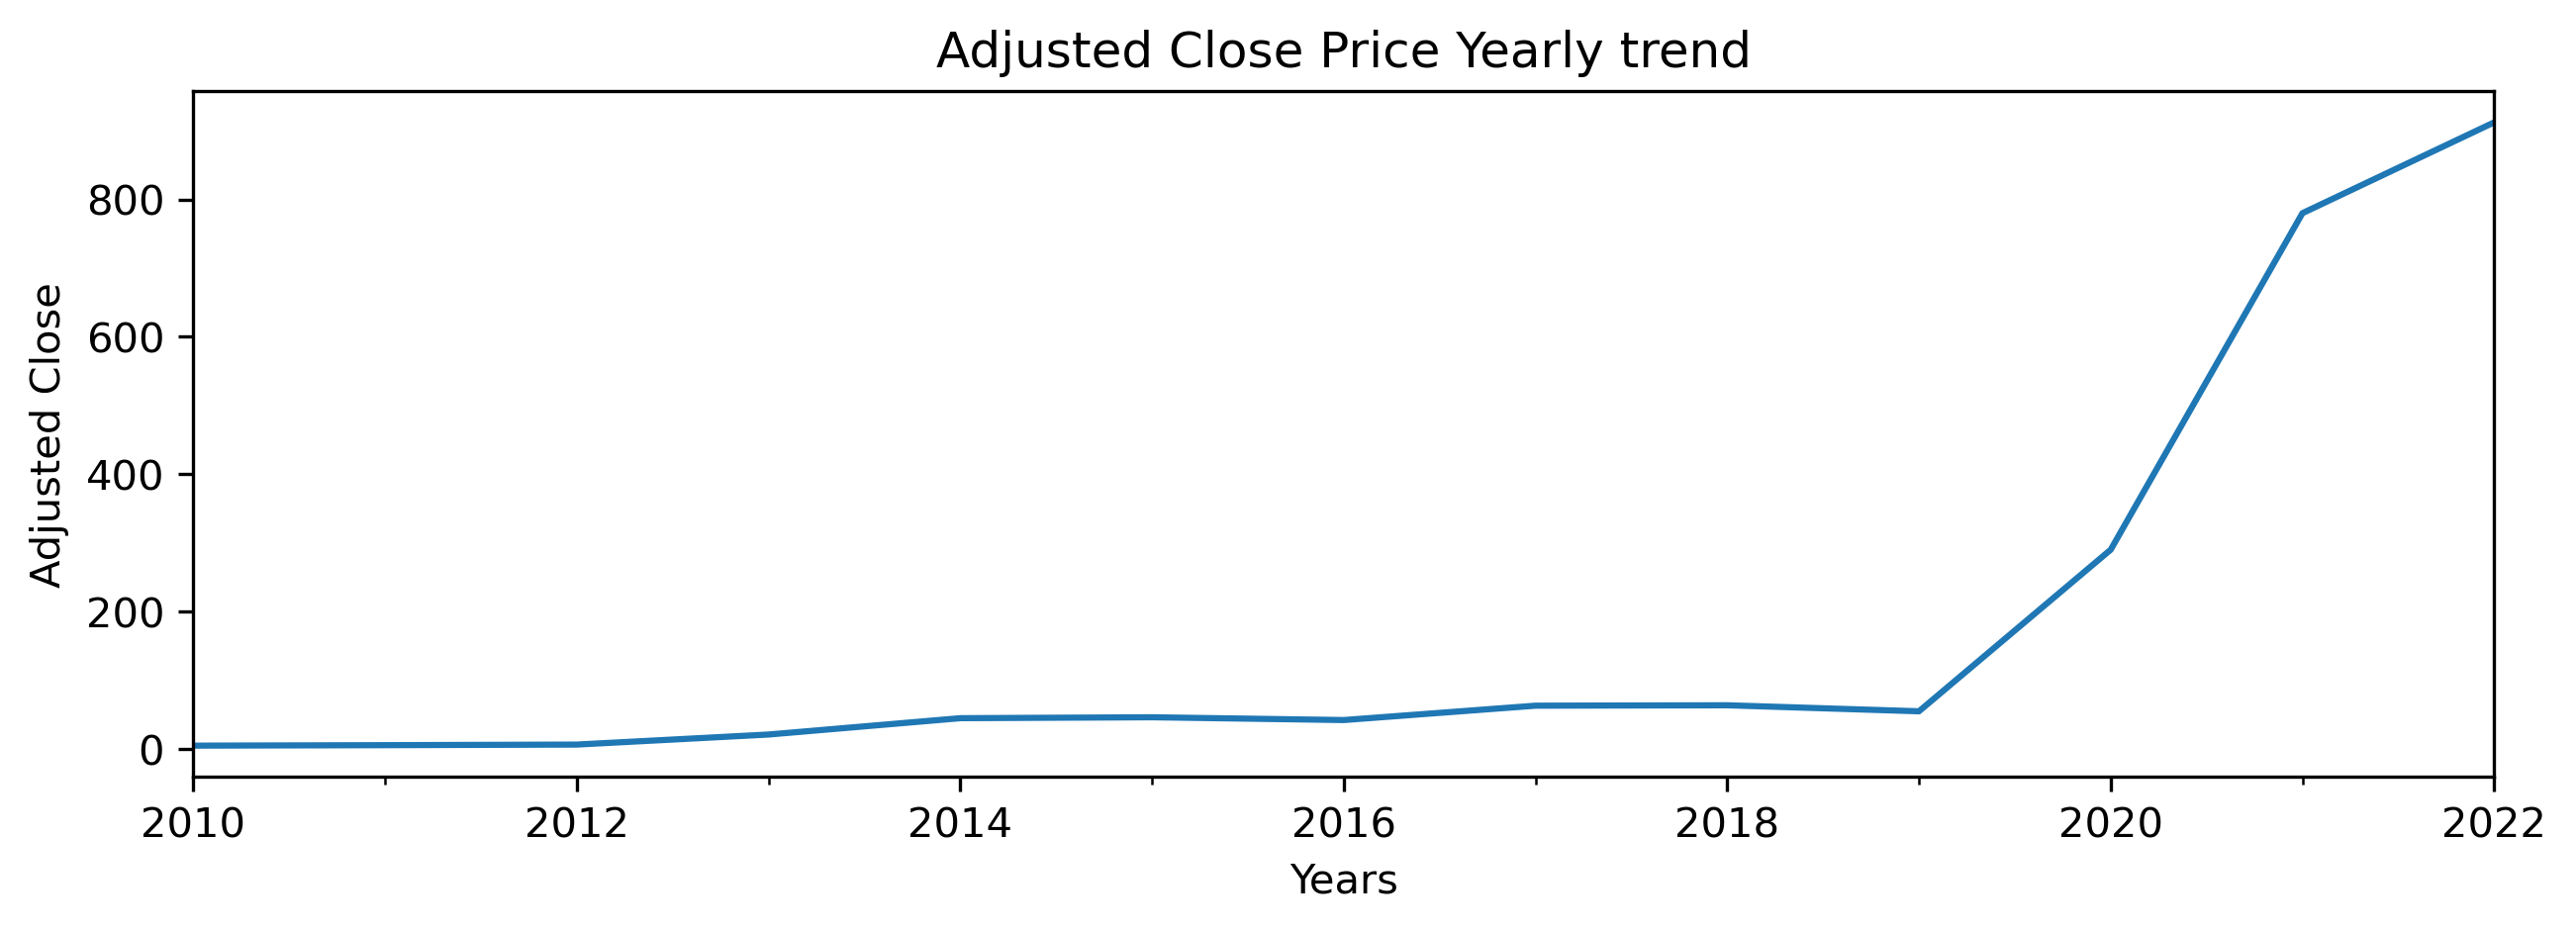

In [12]:
#Now let's view the yearly trend of the stock prics.
plt.figure(figsize=(10, 3), dpi=300)
df['Adj Close'].resample('Y').mean().plot()
plt.xlabel("Years") 
plt.ylabel("Adjusted Close")
plt.title("Adjusted Close Price Yearly trend")

In [13]:
#We are now down with our EDA and will only be using the lag of Adj Close to predict the stock prices
df=df[["Adj Close"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000 entries, 2010-07-01 to 2022-05-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  3000 non-null   float64
dtypes: float64(1)
memory usage: 46.9 KB


# The LSTM MODEL

In [14]:
#Now let's prepare the dataframe which we will be using for our LSTM model.
#We will perform a deepcopy to make our new dataframe since we want to keep our original dataframe.
def df_for_LSTM(df, lookbacks):
    #Let's set the Date column as our index as well.
    copy=dc(df)
    for i in range(1, lookbacks+1):
        copy[f"Adj Close -{i}"]=copy["Adj Close"].shift(i)

    copy.dropna(inplace=True) #This is because the first (lookback)th values will have no preceeding values.So we will exclude those many readings in our new dataframe.
    return copy
#We will consider readings of the past 7 days for each specific reading.
lookbacks=7
new_df=df_for_LSTM(df, lookbacks)
#Note the new size of the df is now 2993 x 8
print(new_df.info())
new_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2993 entries, 2010-07-13 to 2022-05-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Adj Close     2993 non-null   float64
 1   Adj Close -1  2993 non-null   float64
 2   Adj Close -2  2993 non-null   float64
 3   Adj Close -3  2993 non-null   float64
 4   Adj Close -4  2993 non-null   float64
 5   Adj Close -5  2993 non-null   float64
 6   Adj Close -6  2993 non-null   float64
 7   Adj Close -7  2993 non-null   float64
dtypes: float64(8)
memory usage: 210.4 KB
None


,Adj Close,Adj Close -1,Adj Close -2,Adj Close -3,Adj Close -4,Adj Close -5,Adj Close -6,Adj Close -7
Date,,,,,,,,
2010-07-13,3.628000,3.410000,3.480000,3.492000,3.160000,3.222000,3.840000,4.392000
2010-07-14,3.968000,3.628000,3.410000,3.480000,3.492000,3.160000,3.222000,3.840000
2010-07-15,3.978000,3.968000,3.628000,3.410000,3.480000,3.492000,3.160000,3.222000
2010-07-16,4.128000,3.978000,3.968000,3.628000,3.410000,3.480000,3.492000,3.160000
2010-07-19,4.382000,4.128000,3.978000,3.968000,3.628000,3.410000,3.480000,3.492000
...,...,...,...,...,...,...,...,...
2022-05-24,628.159973,674.900024,663.900024,709.419983,709.809998,761.609985,724.369995,769.590027
2022-05-25,658.799988,628.159973,674.900024,663.900024,709.419983,709.809998,761.609985,724.369995
2022-05-26,707.729980,658.799988,628.159973,674.900024,663.900024,709.419983,709.809998,761.609985


In [15]:
#Now we will use numpy to convert each row into an array for further processing
new_df_as_np=new_df.to_numpy()
print(new_df_as_np)

[[  3.628      3.41       3.48     ...   3.222      3.84       4.392   ]
 [  3.968      3.628      3.41     ...   3.16       3.222      3.84    ]
 [  3.978      3.968      3.628    ...   3.492      3.16       3.222   ]
 ...
 [707.72998  658.799988 628.159973 ... 709.419983 709.809998 761.609985]
 [759.630005 707.72998  658.799988 ... 663.900024 709.419983 709.809998]
 [758.26001  759.630005 707.72998  ... 674.900024 663.900024 709.419983]]


In [16]:
#Most machine learning models (especially gradient-based models such as neural networks) perform better when the input features are on a similar scale
#Models like LSTMs (Long Short-Term Memory) and other neural networks converge faster when the input data is scaled.
#Hence let's scale our data!!
scaler=MinMaxScaler(feature_range=(-1, 1))
new_df_as_np=scaler.fit_transform(new_df_as_np)
new_df_as_np

array([[-0.99982387, -1.        , -0.99988585, ..., -0.99989892,
        -0.99889138, -0.99799144],
       [-0.9992694 , -0.99964452, -1.        , ..., -1.        ,
        -0.99989892, -0.99889138],
       [-0.99925309, -0.99909009, -0.99964452, ..., -0.99945873,
        -1.        , -0.99989892],
       ...,
       [ 0.14842743,  0.06871581,  0.01875248, ...,  0.15143259,
         0.15206844,  0.2365192 ],
       [ 0.23306613,  0.14850381,  0.06871581, ...,  0.07722031,
         0.15143259,  0.15206844],
       [ 0.23083194,  0.23313491,  0.14850381, ...,  0.09515387,
         0.07722031,  0.15143259]])

In [17]:
#Now let's set our feature matrix(X) and target vector(y).
X=new_df_as_np[:, 1:] #Use all the columns except the first column with all existing rows to make the feature matrix.
y=new_df_as_np[:, 0]  #Use the first column with all existing rows to make the target vector.
print(X.shape) #2 dimensional
print(y.shape) #1 dimensional

(2993, 7)
(2993,)


In [18]:
#Since we will be sequentially going from the 1st day to the nth day to make our predictition we need to reverse each row of our feature matrix.
#Change the form from Adj Close -1	Adj Close -2	Adj Close -3	Adj Close -4	Adj Close -5	Adj Close -6	Adj Close -7 to
                #	   Adj Close -7	Adj Close -6	Adj Close -5	Adj Close -4	Adj Close -3	Adj Close -2	Adj Close -1
#To avoid ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. 
#(You can probably work around this by making a copy of your array  with array.copy().) You make a deepcopy.3 Cells from here you get this error.
X=dc(np.flip(X, axis=1))
X

array([[-0.99799144, -0.99889138, -0.99989892, ..., -0.99986629,
        -0.99988585, -1.        ],
       [-0.99889138, -0.99989892, -1.        , ..., -0.99988585,
        -1.        , -0.99964452],
       [-0.99989892, -1.        , -0.99945873, ..., -1.        ,
        -0.99964452, -0.99909009],
       ...,
       [ 0.2365192 ,  0.15206844,  0.15143259, ...,  0.09496943,
         0.01875248,  0.06871581],
       [ 0.15206844,  0.15143259,  0.07722031, ...,  0.01875248,
         0.06871581,  0.14850381],
       [ 0.15143259,  0.07722031,  0.09515387, ...,  0.06871581,
         0.14850381,  0.23313491]])

In [19]:
#Now we need to split our feature matrix and target vector into the form of training and testing data.
#We'll use 90% of the data for training and 10% for testing.
split_index=int(len(X)*0.9)
print("Split index: ", split_index)
X_train=X[0:split_index]
X_test=X[split_index: ]
y_train=y[0:split_index]
y_test=y[split_index: ]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Split index:  2693
(2693, 7) (300, 7) (2693,) (300,)


In [20]:
#PyTorch requires an extra dimension for training and testing data due to the way it handles batches of inputs in neural networks.
#The typical structure of input data is: (N,C,L)
#N is the batch size (number of samples) i.e the number of readings you have. In this case 2394
#C is the number of input channels (e.g., 1 for univariate time series, 3 for RGB images). In this case there are 7 time steps.
#L This indicates the number of features(unique) provided for each time step. 
#Since we are only using closing price, this feature is represented as 1.

X_train=X_train.reshape(-1, lookbacks, 1)
X_test=X_test.reshape(-1, lookbacks, 1)

y_train=y_train.reshape(-1, 1)
y_test=y_test.reshape(-1, 1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2693, 7, 1) (300, 7, 1) (2693, 1) (300, 1)


In [21]:
#Converting all the values to tensors for further processing.
X_train=torch.tensor(X_train).float()
X_test=torch.tensor(X_test).float()
y_train=torch.tensor(y_train).float()
y_test=torch.tensor(y_test).float()

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([2693, 7, 1]) torch.Size([300, 7, 1]) torch.Size([2693, 1]) torch.Size([300, 1])


In [22]:
#In PyTorch, Dataset and DataLoader are two essential components for handling and preparing data for training and evaluation of models.
#The Dataset class is an abstract class that allows you to define how your data is structured and accessed. 
#It acts as a blueprint for creating custom datasets tailored to your specific data.
#The DataLoader class provides an efficient way to load data from a Dataset. It is used to create batches of data, shuffle the dataset.

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset=TimeSeriesDataset(X_train, y_train)
test_dataset=TimeSeriesDataset(X_test, y_test)

batch_size=16 # This line sets the size of each batch to 16. In other words, when you train or test your model, the data will be fed in groups of 16 
#samples at a time. Using batches helps in optimizing the training process and makes better use of memory, especially when working with large datasets.

#shuffle=True. This argument enables shuffling of the training dataset at the beginning of each epoch. 
#Shuffling is beneficial during training because it ensures that the model does not learn the order of the training data, 
#which helps improve generalization and prevents overfitting.If shuffle=False it might learn unwanted patterns.
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#Shuffling the testing data set will result in results which make no sense.
#When shuffle=True is set for the test dataset, the samples will be presented to the model in a random order during evaluation. 
#This means that the order in which you evaluate the model's predictions will not correspond to the original order of the test data.

In [23]:
class LSTM(nn.Module):
    # Input_size: Number of features. This refers to the number of distinct variables in the feature matrix. One feature has 7 different values(last 7 days of closing value(single variable)).
    #This is one because we are looking only at the closing value.
    # Hidden_size: This defines how many neurons will be in each hidden layer of the LSTM.
    # Each neuron applies an activation function to the result of the weighted sum of its inputs (adjusted by the bias).
    # The number of neurons in a layer determines how many outputs (activations) will be produced by that layer.
    # Each neuron contributes one activation based on its inputs, weights, and bias.
    # num_stacked_layers: In the context of a recurrent neural network (RNN) such as an LSTM (Long Short-Term Memory) network, num_stacked_layers  
    # typically refers to the number of hidden layers (or layers of LSTM units) that are stacked on top of each other.
    
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size=hidden_size
        self.num_stacked_layers=num_stacked_layers
        self.lstm=nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True) #It is used to specify the expected input shape of your data.
        
        #The fully connected layer (self.fc) only operates on the output of the last hidden layer (the final output from the LSTM), 
        #not on the values from all hidden layers. Here we have to convert the final layer output of size(hidden_size(no. of neurons in a layer)) to a single value.
        self.fc=nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size=x.size(0) #x.size(0) retrieves the size of the first dimension of the tensor x. 
        #In the context of neural networks, this dimension usually represents the batch size—the number of samples in a batch of input data.
        #It allows the model to determine how many samples are being processed in the current batch, 
        #facilitating batch-wise computations throughout the rest of the forward pass.
        h0=torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0=torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)

        out, _=self.lstm(x, (h0, c0))
        out=self.fc(out[:, -1, :])
        return out

In [24]:
#This ensures that any operation involving random numbers (such as initializing weights in neural networks, shuffling data, etc.) 
#produces the same result each time the code is run, as long as the seed is kept the same. It is important for reproducibility and consitency of results.
seed=5
torch.manual_seed(seed)

model=LSTM(1, 8, 1)
model

LSTM(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [25]:
def train_one_epoch():
    model.train(True)#This sets the model to training mode
    print(f"Epoch {epoch + 1}")
    running_loss=0.0
    #For each batch the weights and biases are updated using backpropogation and gradient descent.
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch= batch[0], batch[1]
        output=model(x_batch)
        loss=loss_function(output, y_batch)
        running_loss+=loss.item()# .item() Converts a single-element tensor to a standard Python number (float or int).
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print()
        

In [26]:
def validate_one_epoch():
    model.train(False)#This sets the model to evaluation mode
    running_loss=0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch= batch[0], batch[1]
        # torch.no_grad() tells PyTorch to disable gradient tracking. This is important during the evaluation phase because 
        #you do not need to compute gradients when you are not updating model parameters.
        with torch.no_grad():
            output=model(x_batch)
            loss=loss_function(output, y_batch)
            running_loss+=loss.item()

    avg_loss_across_batches=running_loss / len(test_loader)
    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("*"*50)
    print()

In [27]:
learning_rate=0.001
num_epochs=120
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    

Epoch 1

Val Loss: 0.197
**************************************************

Epoch 2

Val Loss: 0.120
**************************************************

Epoch 3

Val Loss: 0.104
**************************************************

Epoch 4

Val Loss: 0.100
**************************************************

Epoch 5

Val Loss: 0.097
**************************************************

Epoch 6

Val Loss: 0.094
**************************************************

Epoch 7

Val Loss: 0.092
**************************************************

Epoch 8

Val Loss: 0.087
**************************************************

Epoch 9

Val Loss: 0.082
**************************************************

Epoch 10

Val Loss: 0.077
**************************************************

Epoch 11

Val Loss: 0.073
**************************************************

Epoch 12

Val Loss: 0.068
**************************************************

Epoch 13

Val Loss: 0.062
***********************************************

In [28]:
#Now we need to convert our scaled values between -1 and 1 back to their original values.
with torch.no_grad():
    predicted=model(X_train).numpy()
train_predictions=predicted.flatten() #This will convert a multi-dimensional array into a single dimension array.
dummies=np.zeros((X_train.shape[0], lookbacks+1))#lookback +1 because that is the number of columns in new_df.
#X_train.shape[0] gives us the number of rows in X_train.
dummies[:, 0]=train_predictions
dummies=scaler.inverse_transform(dummies)

train_predictions=dc(dummies[:, 0])
train_predictions

array([  4.90810477,   4.99388591,   5.21047689, ..., 671.13211209,
       659.13174369, 668.51693864])

In [29]:
#Now we need to convert our scaled values between -1 and 1 back to their original values.
dummies=np.zeros((X_train.shape[0], lookbacks+1))#lookback +1 because that is the number of columns in new_df.
#X_train.shape[0] gives us the number of rows in X_train.
dummies[:, 0]=y_train.flatten()
dummies=scaler.inverse_transform(dummies)

new_y_train=dc(dummies[:, 0])
new_y_train

array([  3.6280031 ,   3.96798442,   3.97799892, ..., 654.86999587,
       669.99999841, 662.15997416])

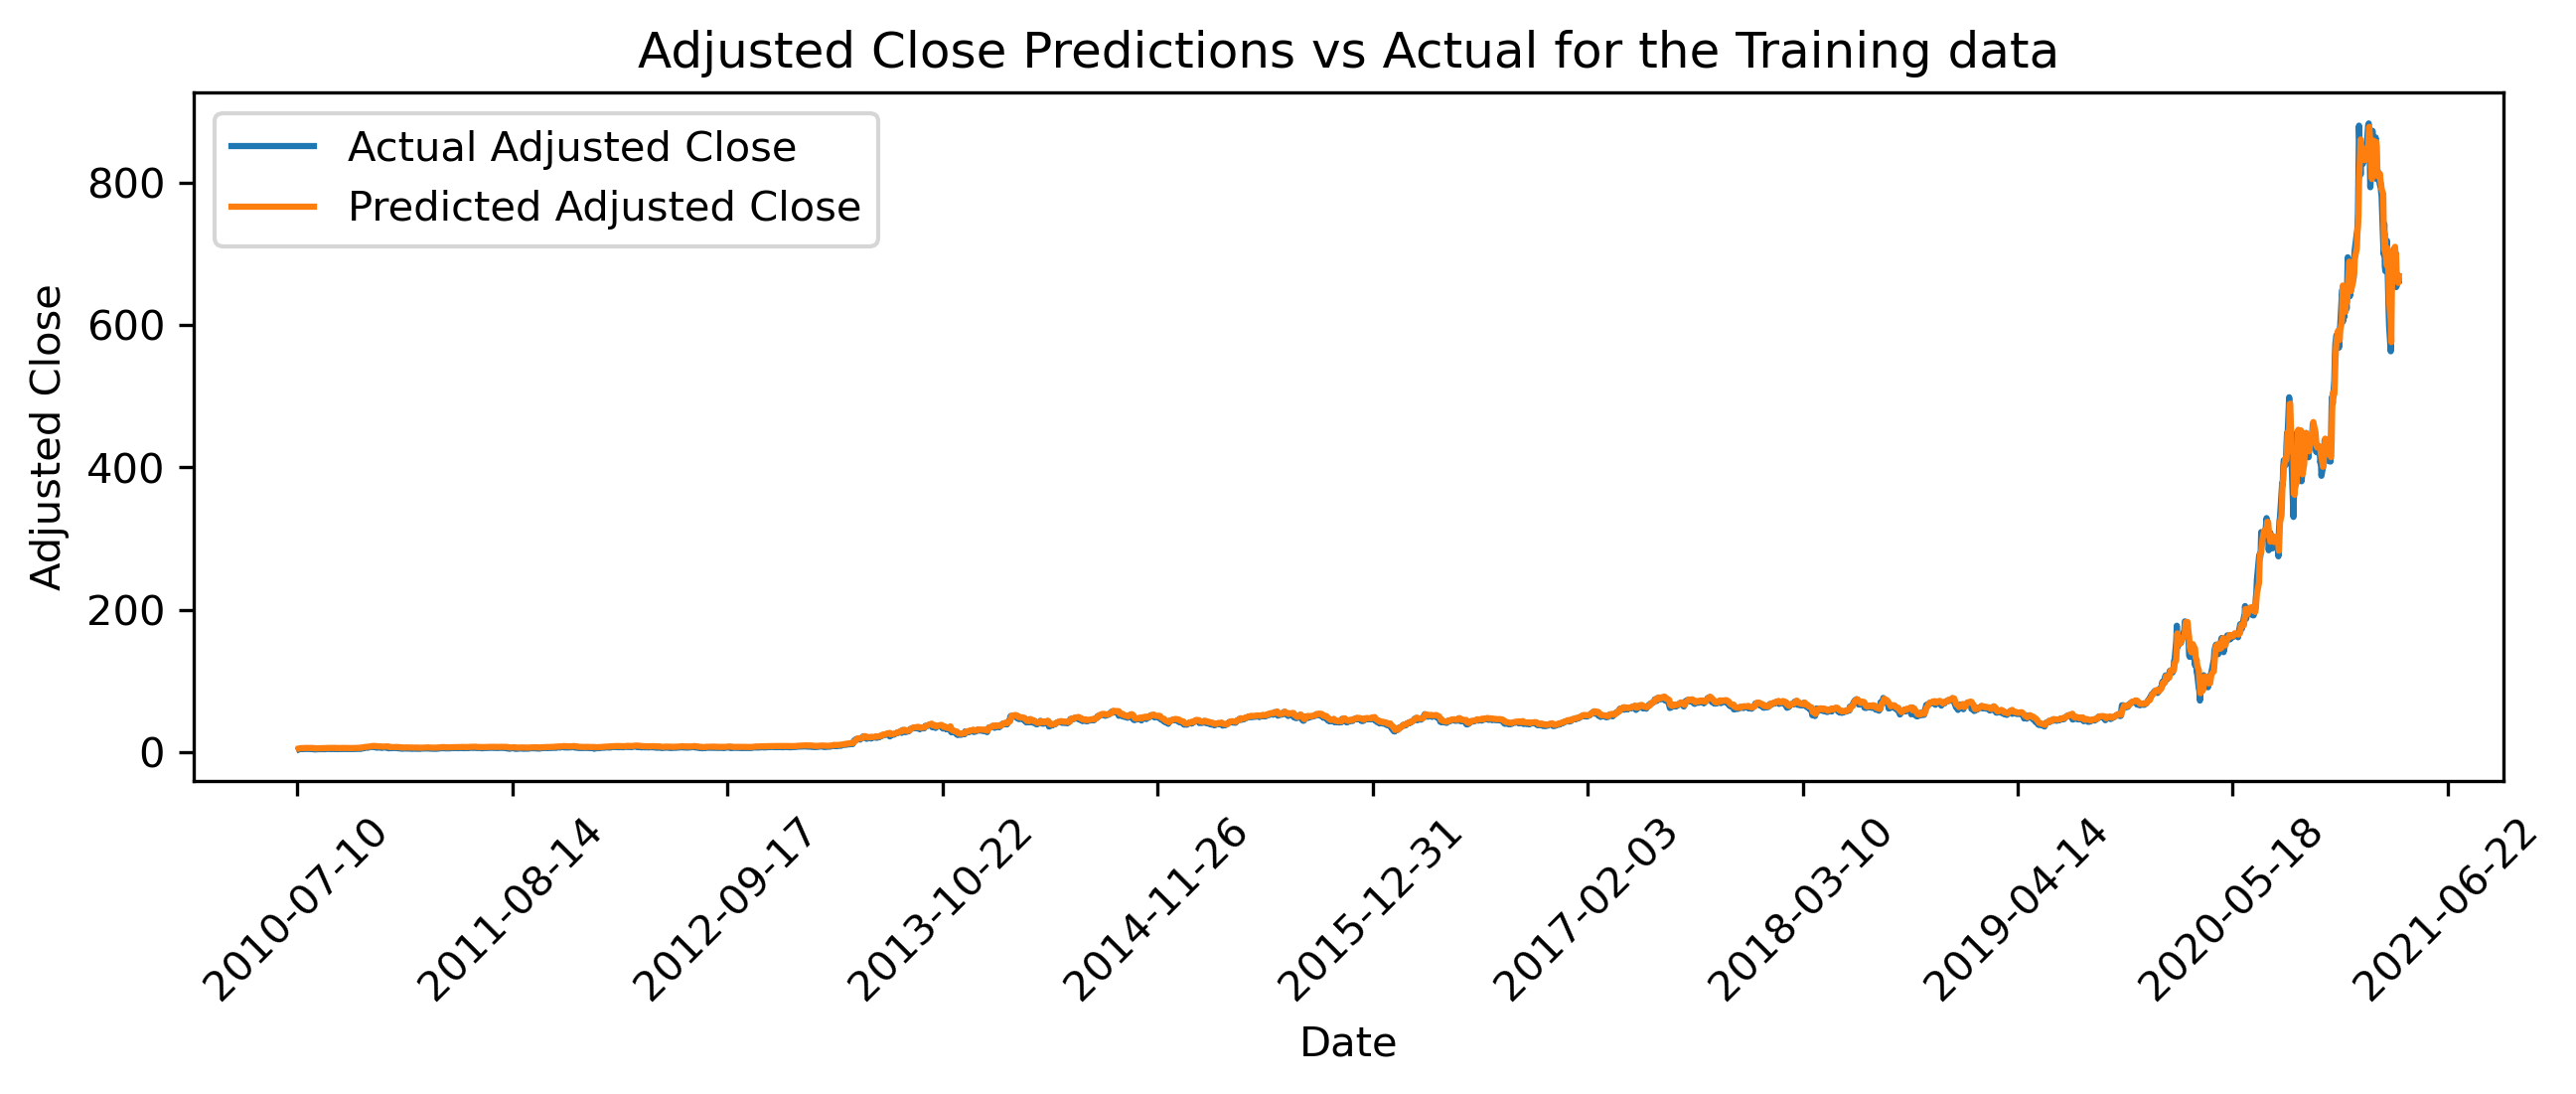

In [30]:
size=int(len(X_train))#Same as split_index.
#Plot the graph of the Training Set.
plt.figure(figsize=(10, 3), dpi=300)
plt.plot(new_df.iloc[:size, :].index, new_y_train, label="Actual Adjusted Close")
plt.plot(new_df.iloc[:size, :].index, train_predictions, label="Predicted Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title("Adjusted Close Predictions vs Actual for the Training data")
plt.legend()
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set x-axis tick frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Show at most 12 ticks
plt.show()

In [31]:
#Now we need to convert our scaled values between -1 and 1 back to their original values.
test_predictions=model(X_test).detach().flatten()
dummies=np.zeros((X_test.shape[0], lookbacks+1))#lookback +1 because that is the number of columns in the shifted_df.
#X_train.shape[0] gives us the number of rows in X_train.
dummies[:, 0]=test_predictions
dummies=scaler.inverse_transform(dummies)

test_predictions=dc(dummies[:, 0])
#test_predictions

In [32]:
#Now we need to convert our scaled values between -1 and 1 back to their original values.
dummies=np.zeros((X_test.shape[0], lookbacks+1))#lookback +1 because that is the number of columns in the shifted_df.
#X_train.shape[0] gives us the number of rows in X_train.
dummies[:, 0]=y_test.flatten()
dummies=scaler.inverse_transform(dummies)

new_y_test=dc(dummies[:, 0])
#new_y_test

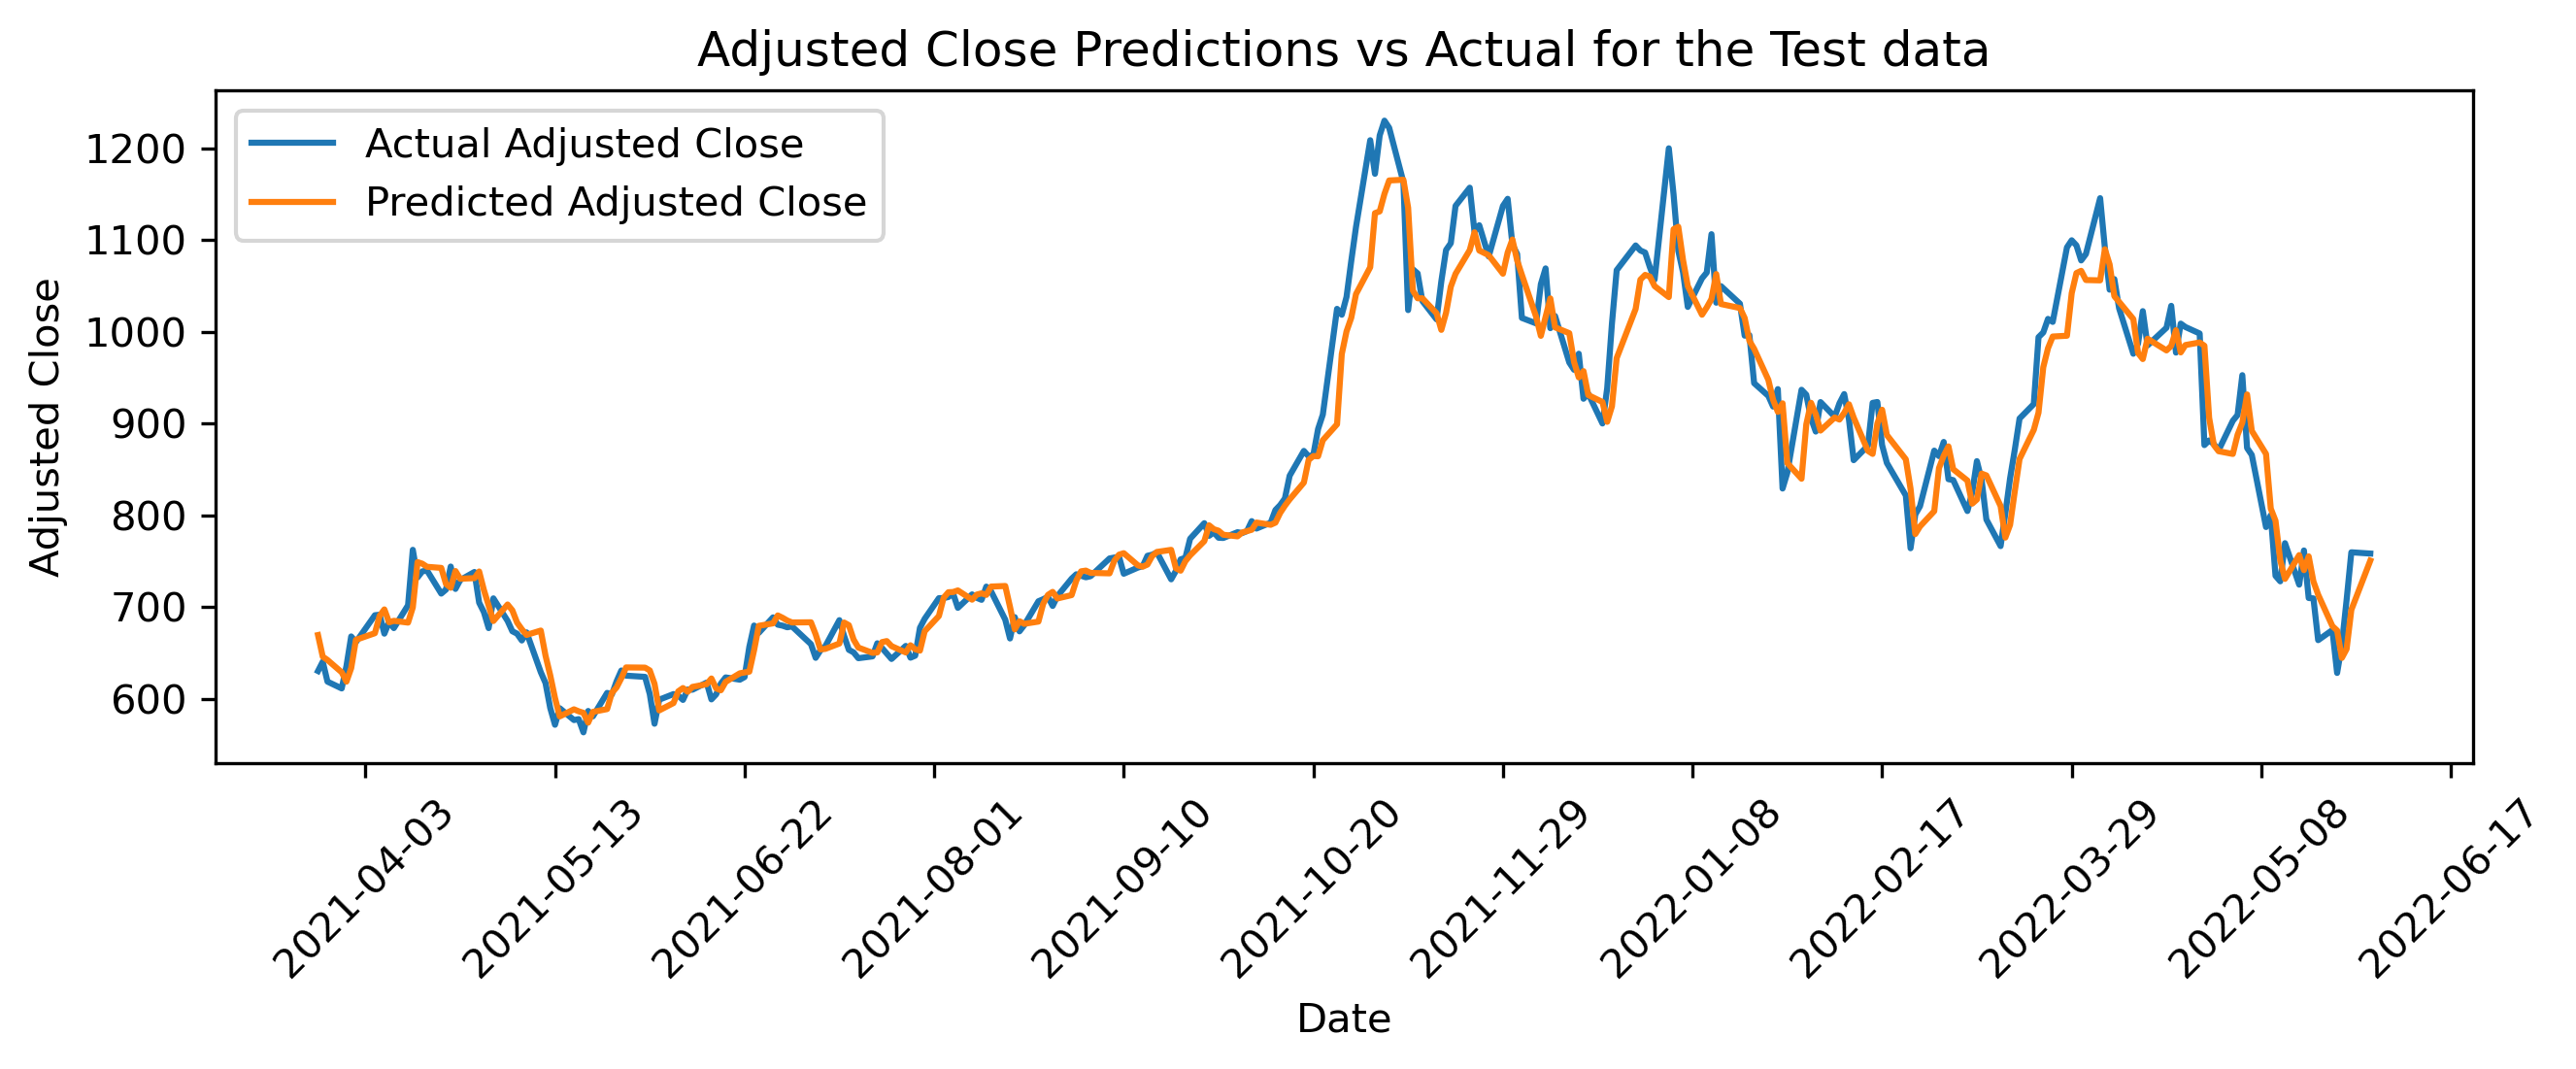

In [33]:
#Plot the graph of the Training Set.
length=len(X)
plt.figure(figsize=(10, 3), dpi=300)
plt.plot(new_df.iloc[size:length, :].index, new_y_test, label="Actual Adjusted Close")
plt.plot(new_df.iloc[size:length, :].index, test_predictions, label="Predicted Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Adjusted Close")
plt.title("Adjusted Close Predictions vs Actual for the Test data")
plt.legend()
plt.xticks(rotation=45)

# Set x-axis tick frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Show at most 12 ticks
plt.show()

In [34]:
mae=mean_absolute_error(test_predictions, new_y_test)
print("The LSTM model gives us a mean absolute error of: {0:.3f}".format(mae))

The LSTM model gives us a mean absolute error of: 25.187


# The ARIMA MODEL

In [35]:
df=pd.read_csv("archive\TSLA.csv")

In [36]:
df["Date"]=pd.to_datetime(df["Date"])
df.set_index(df["Date"], inplace=True)
df.drop("Date", axis=1, inplace=True)
df=df[["Close"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000 entries, 2010-07-01 to 2022-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3000 non-null   float64
dtypes: float64(1)
memory usage: 46.9 KB


In [37]:
df.head()

,Close
Date,
2010-07-01,4.392
2010-07-02,3.840
2010-07-06,3.222
2010-07-07,3.160
2010-07-08,3.492


In [38]:
#By ignoring seasonality, the ARIMA model focuses purely on the historical patterns, autocorrelations, and random movements in the stock's closing prices.
#When set to True, the trace argument will print details of the model selection process, showing the different combinations of ARIMA parameters being tested
#and their associated metrics, like the Akaike Information Criterion (AIC).
model = auto_arima(df["Close"], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23540.262, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23538.838, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=23538.912, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23539.525, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23540.519, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23540.496, Time=1.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23541.422, Time=1.74 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=23538.190, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=23539.844, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=23539.844, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=23538.264, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=23540.635, Time=0.63 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 10.719 seconds
              

In [39]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0] #yhat = output[0] extracts only the first (and only) value from output
    return yhat #Return the prediction

# Split data into train and test sets
X = df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
#The history list will grow as the model makes predictions on the test set, simulating how the model would behave by learning from previous predictions.
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

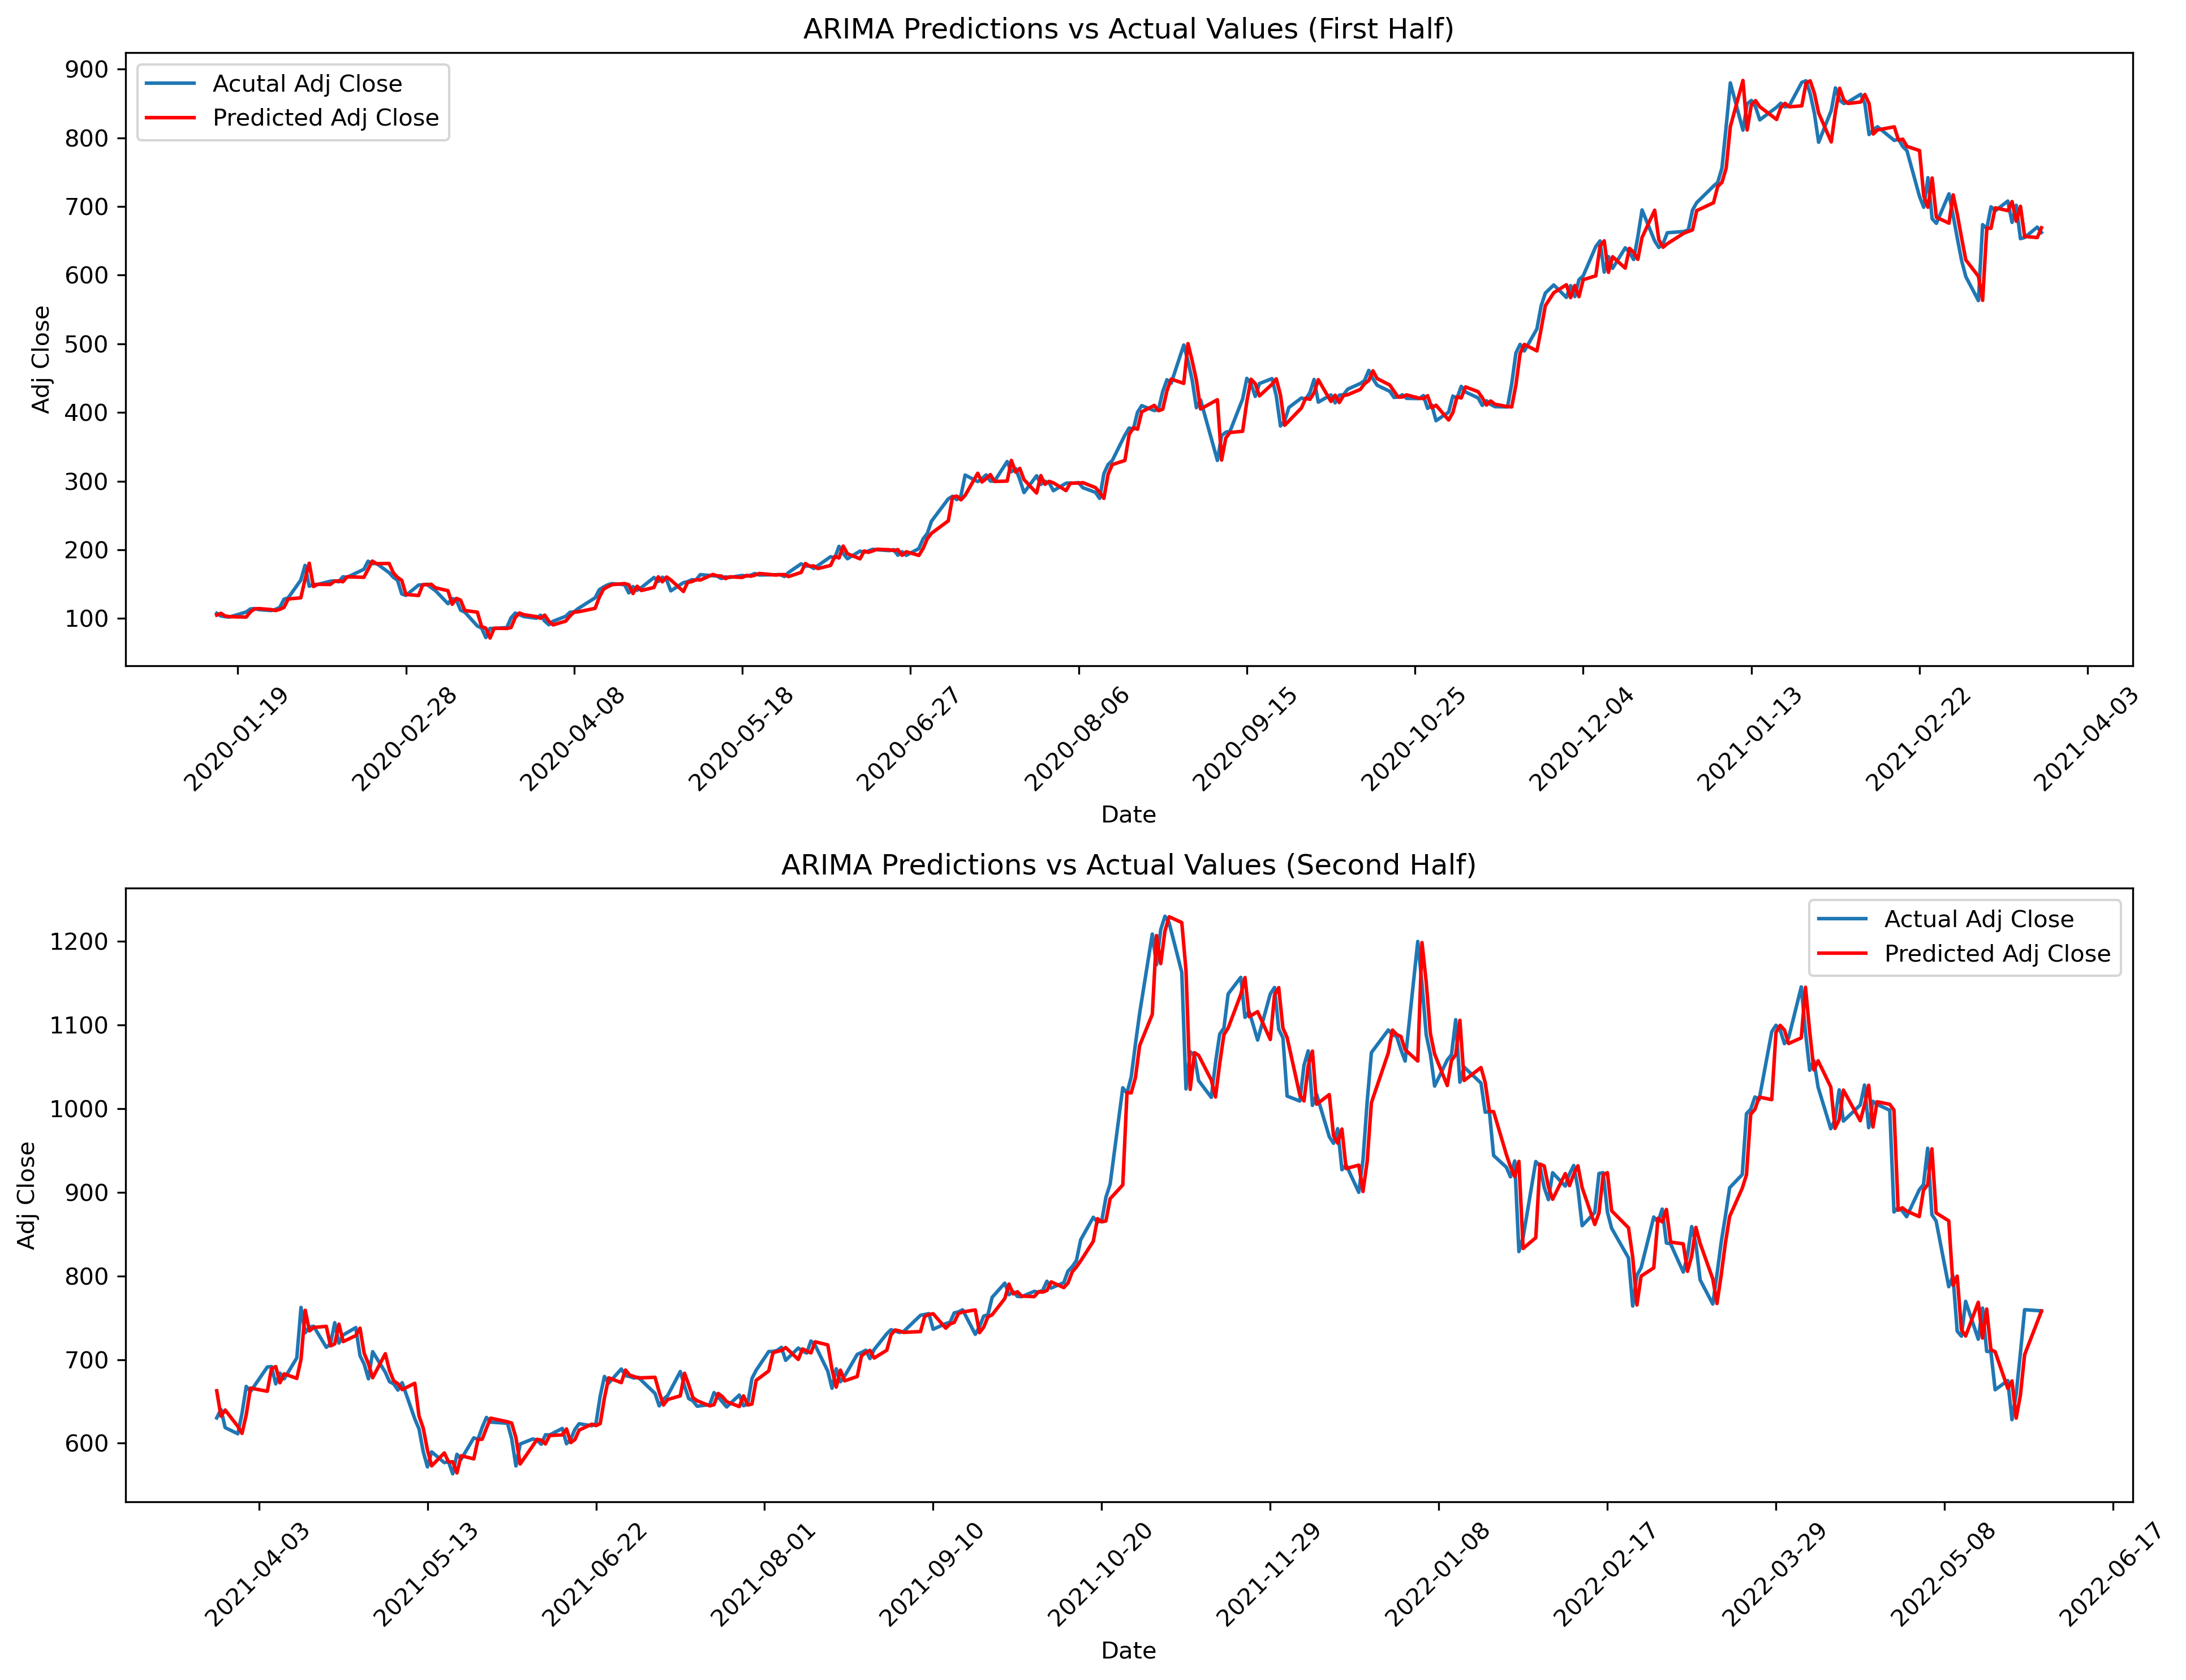

In [40]:
#Let's plot the final graph!!!

# Calculate midpoint for splitting
length = int((len(X) - size) / 2)

plt.figure(figsize=(13, 10), dpi=300)  # Increased figure height for two plots
# First subplot: The first half of the data
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(df.iloc[size:size+length, :].index, test[:length], label="Acutal Adj Close")
plt.plot(df.iloc[size:size+length, :].index, predictions[:length], color='red', label="Predicted Adj Close")
plt.title("ARIMA Predictions vs Actual Values (First Half)")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Set x-axis tick frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Show at most 10 ticks

# Second subplot: The second half of the data
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(df.iloc[size+length:, :].index, test[length:], label="Actual Adj Close")
plt.plot(df.iloc[size+length:, :].index, predictions[length:], color="red", label="Predicted Adj Close")
plt.title("ARIMA Predictions vs Actual Values (Second Half)")
plt.xlabel("Date")
plt.ylabel("Adj Close")
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Set x-axis tick frequency
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))  # Show at most 12 ticks

# Show the complete figure
plt.tight_layout()  # Adjusts layout to avoid overlap
plt.show()


In [41]:
mae=mean_absolute_error(predictions, test)
print("The ARIMA model gives a mean absolute error of: {0: .3f}".format(mae))

The ARIMA model gives a mean absolute error of:  18.373
